In [30]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import open3d as o3d
import utils

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
c = np.load('casper/calib.npy', allow_pickle=True).item()
K0 = c['K0']
d0 = c['d0']
K1 = c['K1']
d1 = c['d1']
R = c['R']
t = c['t']

Question: How do we get the Intrinsic and Extrinsic parameters if the camera is not calibrated?
Intrinsics: Calibrate with checkerboard
Extrinsics: Ex-11 Visual Odometry

In [5]:
im0 = cv2.imread("casper/sequence/frames0_0.png")
size = (im0.shape[1], im0.shape[0])
stereo = cv2.stereoRectify(c['K0'], c['d0'], c['K1'],
                           c['d1'], size, c['R'], c['t'], flags=0)
R0, R1, P0, P1 = stereo[:4]
maps0 = cv2.initUndistortRectifyMap(c['K0'], c['d0'], R0, P0, size, cv2.CV_32FC2)
maps1 = cv2.initUndistortRectifyMap(c['K1'], c['d1'], R1, P1, size, cv2.CV_32FC2)

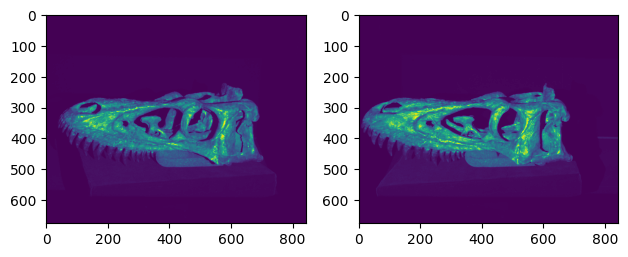

In [9]:
def load_and_rectify(seq, map):
    ims = []
    for i in range(26):
        im = cv2.imread(f"casper/sequence/frames{seq}_{i}.png")
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY).astype(float) / 255.0
        im = cv2.remap(im, *map, cv2.INTER_LINEAR)
        ims.append(im)
    return ims

ims0 = load_and_rectify(0, maps0)
ims1 = load_and_rectify(1, maps1)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(ims0[0])
axs[1].imshow(ims1[0])
plt.tight_layout()
plt.show()

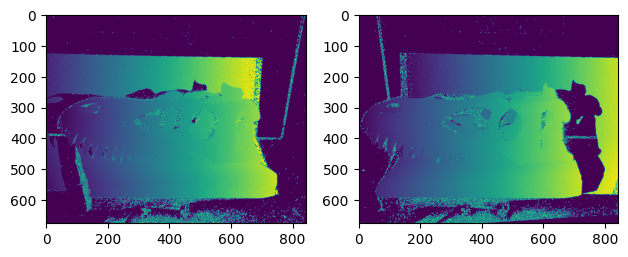

In [15]:
def unwrap(ims):
    n_1 = 40

    fft_primary = np.fft.rfft(ims[2:18], axis=0)
    theta_primary = np.angle(fft_primary[1])

    fft_secondary = np.fft.rfft(ims[18:26], axis=0)
    theta_secondary = np.angle(fft_secondary[1])

    theta_c = (theta_secondary - theta_primary) % (2 * math.pi)
    o_primary = np.round((n_1 * theta_c - theta_primary) / (2 * math.pi))
    theta = (((2 * math.pi) * o_primary + theta_primary) / n_1) % (2 * math.pi)
    return theta

theta0 = unwrap(ims0)
theta1 = unwrap(ims1)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(theta0)
axs[1].imshow(theta1)
plt.tight_layout()
plt.show()

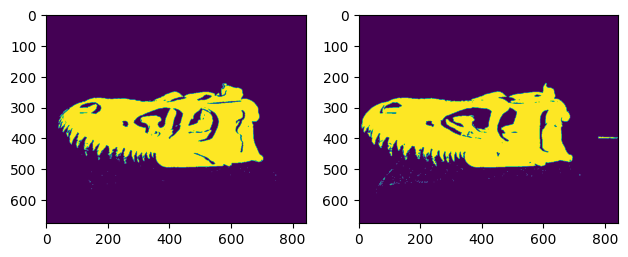

In [23]:
def getmask(ims, tau):
    diff = ims[0] - ims[1]
    mask = np.zeros_like(diff)
    mask[diff > tau] = 1
    return mask

tau = 0.06
mask0 = getmask(ims0, tau)
mask1 = getmask(ims1, tau)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(mask0)
axs[1].imshow(mask1)
plt.tight_layout()
plt.show()

In [24]:
q0s = []
q1s = []
disparity = np.zeros_like(theta0)

for i in range(theta0.shape[0]):
    for j0 in range(theta0.shape[1]):
        if mask0[i, j0] == 1:
            diff = math.inf
            j1_pair = None
            for j1 in range(theta1.shape[1]):
                if mask1[i, j1] == 1:
                    newdiff = abs(theta0[i, j0] - theta1[i, j1])
                    if newdiff < diff:
                        diff = newdiff
                        j1_pair = j1
            if j1_pair is not None:
                disparity[i, j0] = j0 - j1_pair
                q0s.append(np.array([j0, i]))
                q1s.append(np.array([j1_pair, i]))

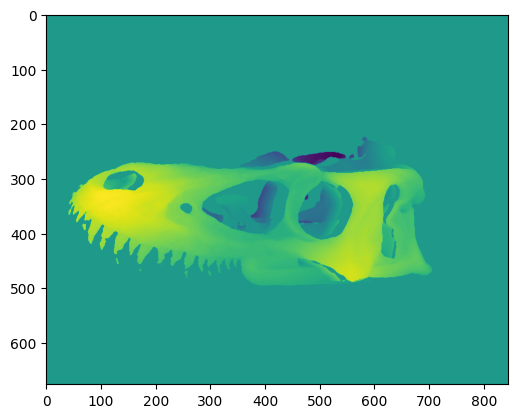

In [29]:
disparity = cv2.medianBlur(disparity.astype(np.float32), 5)
plt.imshow(disparity)

In [40]:
q0st = np.vstack(q0s).T.astype(float)
q1st = np.vstack(q1s).T.astype(float)

Qs = utils.Pi(cv2.triangulatePoints(P0, P1, q0st, q1st))
behind_cam_idx = Qs[2] < 0
Qs_real = Qs[:, ~behind_cam_idx]


In [41]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Qs_real.T)
o3d.visualization.draw_geometries([pcd])